Quantum Optimal Control and GRAPE🍇
===================================
**The problem:** Find, numerically, a pulse $\epsilon(t)$ to achieve some unitary transformation $U(\epsilon(t))$.

**The solution:** Try a butt-load of different pulses $\epsilon(t)$ until you find a good one, but be smart about it.

To achieve the solution we'll first need a measure of "goodness", for that we'll use the **fidelity**. The fidelity of between two states is the absolute value squared of their overlap 
(i.e. $F[|\psi>, |\phi>] = \parallel <\psi|\phi>\parallel^2$ where $F[|\psi>, |\phi>]$ is the fidelity bewtween the states $|\psi>$ and $|\phi>$)
and it's value is between 0 and 1.

The problem now states "*Find $\epsilon(t)$ that maximizes $F[U(\epsilon(t)),\ U_{target}]$*". To solve the problem we'll first calculate the fidelity of some inital random pulse, and the gradient of the pulse ($\vec{\nabla}_{\vec{\epsilon}} F[U(\vec{\epsilon})]$ as defined later) with the two of this in hand we can use some optimization algorithm such as BFGS to find
an optimal pulse.

$\rightarrow$ calculate $U(\epsilon(t))$ $\rightarrow$ calculate the gradient $\rightarrow$ optimize using the BFGS algorithm $\rightarrow$

## 👉 Calculate $U(\epsilon(t))$
The first thing we'll need to figure out is how to calculate the effect of the pulse $\epsilon(t)$. To do so we'll need to solve the time-dependent schrodinger equation for the system
with this pulse. So first what we'll do is divide the continous pulse $\epsilon(T)$ into a piece-wise constant function ($\epsilon(t) \rightarrow (\epsilon_n)_{n=0}^N$), that way we can solve many time-independent schrodinger equations and combine them together at the end. The solution of each time piece is
$$U_k = \exp(\ \frac{i}{\hbar}\delta t H(t_k)\ )$$
And over the entire pulse the transformation is
$$U(\epsilon(t)) = U_N U_{N-1} \dots U_2 U_1$$
We haven't defined the hamiltonian yet (since this could be used for many different hamiltonians), so the general hamiltonian we'll consider is with
time-independent part + the time-dependent part from the pulses.
$$H(t_k) = H_0 + \sum_j \epsilon_j(t_k) H_j$$
Where $\epsilon_j(t_k)$ is the j-th pulse at the k-th time step.

<!-- ![](./const_piece.png) -->

## 👉 Calculate the gradient
We want to calculate how sensative the fidelity is to changes in a single piece of of a pulse ($\frac{\partial F}{\partial \epsilon_j(t_k)}$). I won't bore you with the details, this is the solution
$$\frac{\partial U}{\partial \epsilon_j (t_k)} = U_n U_{N-1} \dots U_{k+1} \frac{\partial U_k}{\partial \epsilon_j (t_k)} U_{k-1} \dots U_1$$
$$ \frac{\partial U_k}{\partial \epsilon_j (t_k)} =  \frac{\partial \exp(\ \frac{i \delta t}{\hbar} H(t_k)\ )}{\partial \epsilon_j (t_k)}$$
There are ways to simplify these expressions and make it computationally faster, if you want you can read the manuscript.

With $F[U(\epsilon(t))]$ and the gradient we can use an optimization algorithm to find optimal point in the function space $\vec{\epsilon} \in R^{N \times M}$ (N = # time divisions, M = # pulses)

<img src="const_piece.png" alt="Example pulse" style="width: 700px;"/>

## 👉 Constraints
There are many reaons why we might want to add constraints to the algorithm, limits of our instruments, general preference for weaker pulses
to minimize non-linear phenomena, etc...

I won't go into the mathematical details, but there are two main types of constraints:

**🔹 Hard constraints -** We limit the search area to give an hard cut-off limit for some value. This could be the pulse amplitude, for example,
that must be lower the the maximum output power of the pulse generating instrument, and can't go any higher even if we really want to.

**🔹 Soft constraints -** We give general pereference for some pulses over other. Continueing with the pulse amplitude example, even if our instrument could output rather strong pulses, we might prefer them to be as weak as they can, to reduce non-linear phenomena and to not damage our instrument etc... We use the method of Lagrange multipliers to implement the soft constraints, where $\lambda$ of each constraint defins how "strong" it is.

Example of constraints:
  * Pulse amplitude
  * Pulse bandwidth
  * Photon number
  * "Forbidden" qubit levels
  * $\dots$

# 👉 Example: Simple Qubit with Constraints 💡🚧
This is almost the simplest example use case of the GRAPE🍇 library. There is a qubit interacting with two time-varying control drives (see this project's manuscript) and we want to understand how to control the qubit. The qubit begins in some initial state ($|0>$ in this example) and we want to find the control drives that would take the qubit to some target state ($|1>$ in this example).

### Imports

In [1]:
import sys
sys.path.insert(1, r'..') # Path to grape code, won't be a problem if it was downloaded from conda
import grape  # This is mine :)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import qutip as qt  # qutip is used only to easily define basic quantum operators and turn them into numpy ndarrays
import scipy.ndimage as ndi

plt.style.use("ggplot")

### 👉 Ladder operators
Setting up qubit ladder operators, $\hat{q}$ and $\hat{q}^\dagger$

In [2]:
q = qt.destroy(2)
qd = q.dag()
# Turn qutip objects to numpy
q = np.array(q)
qd = np.array(qd)

### 👉 Hamiltonians ⚡
In this example we'll consider a very simple qubit, the Hamiltonian of which is given by:
$$\hat{H}_0 = \omega\hat{q}^\dagger \hat{q}$$
We use two microwave pulses to control the qubit, I and Q. The Hamiltonians describing the interaction between the qubit and the pulses are:
$$\hat{H}_I = (\hat{q} + \hat{q}^\dagger)$$
$$\hat{H}_Q = (\hat{q} - \hat{q}^\dagger)\cdot i$$
The amplitude of the microwave pulses varies with time (this is how we control the system). The amplitude of the I pulse is given by $\epsilon_I(t)$ and of the Q by $\epsilon_Q(t)$. The total Hamiltonian of the system is the sum:

$$\hat{H} = \hat{H}_0 + \epsilon_I(t) \hat{H}_I + \epsilon_Q(t) \hat{H_Q}$$

We seek to find optimal $\epsilon_I (t)$ and $\epsilon_Q (t)$

In [3]:
# Constants
omega = 1

In [4]:
H_0 = omega*qd@q
H_I = qd + q
H_Q = (qd - q)*1j

### 👉 Time variables ⏰
**T** is the total time, **Ns** is the number of time steps and **times** is array of all time steps

In [5]:
T     = 25
Ns    = 200
times = np.linspace(0.0, T, Ns)

### 👉 Initial and target states
Setting initial and target states. $|\psi_{initial}>\ =\ |0>$ and $|\psi_{target}>\ =\ |1>$

In [6]:
psi_initial = np.array(qt.basis(2, 0))
psi_target  = np.array(qt.basis(2, 1))

### 👉 Initial pulses guess
We treat the the drive amplitudes $\epsilon_I(t)$ and $\epsilon_Q(t)$ as step-wise constant function, with step size of $\frac{T}{Ns}$ and a total of $Ns$ steps. This is why, in code, each drive amplitude is a numpy ndarray of length Ns.

This time we are going to be smarter about our initial guess choice. In example one we simply guessed a random wave, which is problematic for several of reason. The main problem with a random initial guess is that it is very much not smooth. We want an initial guess that is close to 0, pretty random and somewhat smooth, this could be achieved by taking the convolution of a guassian with a random array.

In [7]:
def gaussian(size, sigma, amp, graph=False):
    gaussian_window = np.zeros(size)
    for x in range(size):
        gaussian_window[x] = amp * np.exp(-(x - size / 2 ** 2) / sigma ** 2)
        if graph:
            plt.figure()
            plt.plot(times[0:size], gaussian_window)
    return gaussian_window

In [15]:
gaussian_window = gaussian(int(Ns/10), Ns/50, 1)

rand_amp_Q = 1/3000
rand_amp_I = 1/3000

conv_I = (ndi.convolve((np.random.random(Ns) - 0.5) *
                       2 * rand_amp_I, gaussian_window, mode='wrap'))
conv_Q = (ndi.convolve((np.random.random(Ns) - 0.5) *
                       2 * rand_amp_Q, gaussian_window, mode='wrap'))

e_I = conv_I
e_Q = conv_Q

### 👉 Constraints
We'll now define the strength of the constraints (the lagrange multipliers, $\lambda$'s). In this example we will only have soft constraint (instead of hard constraints such as cut-off amplitude and frequency). We'll only define constraints on the amplitude and the bandwidht, $\lambda_{amp}$ and $\lambda_{band}$.

In [16]:
lambda_amp = 0.5e-3
lambda_band = 1e-2

We need to put the multiple drive hamiltonians into one variable and also for the multiple drive amplitudes.
We set a variable, *drive_hamiltonians*, which is a list of all the drive hamiltonians, and a variable, *pulses*, which is a list of the drive amplitudes. Notice that the two lists need to be the same length and that the $i^{th}$ drive hamiltonian in the list correspond to the $i^{th}$ drive amplitude in the list

In [17]:
drive_hamiltonians = [H_I, H_Q]
pulses    = np.array([e_I, e_Q])

### 👉 Creating GRAPE object 🍇
We now create the *GrapePulse* object, which contains all the data on the pulse and can be used for the optimization

In [18]:
grape_pulse = grape.GrapePulse(psi_initial, psi_target, T, Ns, H_0, drive_hamiltonians,
                               pulses, constraints=True, lambda_amp_lin=lambda_amp, lambda_band_lin=lambda_band)

## 👉 Optimizing 🛠
We now run the GRAPE optimization, we can choose to graph the probabilites over the duration of the pulse before and after the optimization

 == Starting Optimization == 
Doing quantum magic, please wait😀

 Epoch 9 ➞  Fidelity: 100.00%  [#######################################]   

 == Optimization finished successfulyafter 9 epochs ==


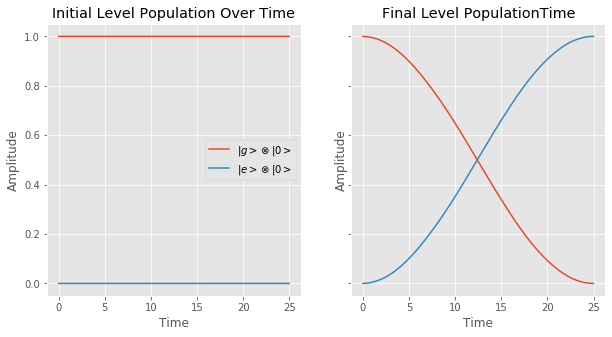

In [19]:
results = grape_pulse.optimize(graph_prob=True)

We get back a dictionary with all the results we need: optimized drive amplitudes, final fidelity, the Hamiltonians (which are allready known if you wrote this script, but usefull if you want to save it to a file), the Hilbert space dimensions and some comments you can add. The dictionary has the form:
* **"pulses"**: *ndarray* of shape (number of drive amplitudes$\ \times\ $number of time steps)
* **"fidelity"**: *float* of the final fidelity
* **"Hamiltonians"**:
    * **"constant"**: *ndarray* matrix of the constant hamiltonian
    * **"drives"**: *list of ndarray* matrices of the drive hamiltonians
* **"dimensions"**: *ndarray* of list of original hilbert space dimensions
* **"comments"**: comments you can add (again, only useful when you save as a file and want to understand what these results mean

### 👉 Graphing the results 📈

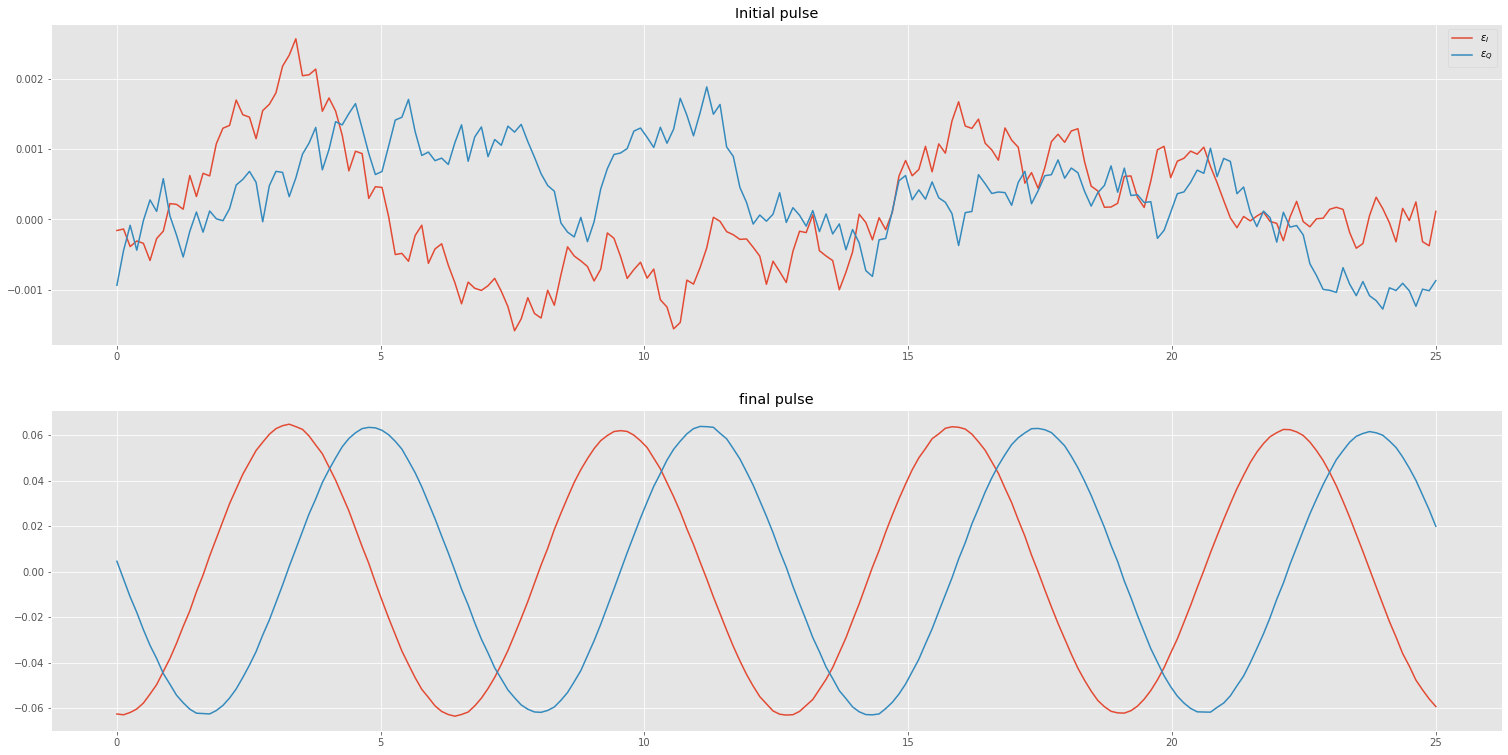

In [20]:
pulses = results["pulses"]

fig, axes = plt.subplots(2, figsize=(26,13))
# --- Initial ---
axes[0].set_title("Initial pulse")
axes[0].plot(times, e_I)
axes[0].plot(times, e_Q)
axes[0].legend([r'$\epsilon_I$', r'$\epsilon_Q$'])
# --- Final ---
axes[1].set_title("final pulse")
axes[1].plot(times,  pulses[0])
axes[1].plot(times,  pulses[1]);

Now we got smooth results as expected

### Checking final fidelity
One last thing we need to check is that the final fidelity is actually close to $1$, let's check that now

In [181]:
print("A fidelity of", results["fidelity"], "was achieved by the optimization")

A fidelity of 0.9998718010565277 was achieved by the optimization
